# Analyzing the European Parliament

In [1]:
import json

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import umap
import umap.plot

from tqdm.auto import tqdm

In [2]:
sns.set_context('talk')

## Download data

In [3]:
# %%bash

# wget --no-clobber https://parltrack.org/dumps/ep_votes.json.lz
# lzip -d ep_votes.json.lz

# wget --no-clobber https://parltrack.org/dumps/ep_meps.json.lz
# lzip -d ep_meps.json.lz

## Transform JSON to dataframes

### MEPs

In [4]:
fname = 'ep_meps.json'

tmp = []
with open(fname) as fd:
    for line in tqdm(fd.readlines()):
        line = line.lstrip('[,]')
        if len(line) == 0:
            continue
        
        data = json.loads(line)
        
#         if not data['active']:
#             continue
        
        tmp.append({
            'UserID': data['UserID'],
            'name': data['Name']['full'],
            'birthday': data['Birth']['date'] if 'Birth' in data else np.nan,
            'active': data['active'],
            'group': data.get('Groups', [{'groupid': np.nan}])[-1]['groupid']  # assumption: last group is latest one. Is this true?
        })

In [5]:
df_meps = pd.DataFrame(tmp)
df_meps['birthday'] = pd.to_datetime(df_meps['birthday'])

df_meps.set_index('UserID', inplace=True)

df_meps['group'].replace({'Group of the European United Left - Nordic Green Left': 'GUE/NGL'}, inplace=True)  # is there a difference?

df_meps.head()

,name,birthday,active,group
UserID,,,,
2307,Hubert PIRKER,1948-10-03,False,PPE
111496,María Auxiliadora CORREA ZAMORA,1972-05-24,False,PPE
110987,Gino TREMATERRA,1940-09-03,False,PPE
1965,Jan MULDER,1943-10-03,False,ALDE
39321,Vicente Miguel GARCÉS RAMÓN,1946-11-10,False,S&D


### Votes

In [6]:
fname = 'ep_votes.json'

tmp = []
tmp_matrix = {}
with open(fname) as fd:
    for line in tqdm(fd.readlines()):
        line = line.lstrip('[,]')
        if len(line) == 0:
            continue
        
        data = json.loads(line)
        tmp.append({
            'date': data['ts'],
            'voteid': data['voteid'],
            'title': data['title']
        })
    
        if 'votes' in data:
            tmp_matrix[data['voteid']] = {
                **{mep['mepid']: '+' for mep_list in data['votes'].get('+', {'groups': {'foo': []}})['groups'].values() for mep in mep_list if 'mepid' in mep},
                **{mep['mepid']: '-' for mep_list in data['votes'].get('-', {'groups': {'foo': []}})['groups'].values() for mep in mep_list if 'mepid' in mep},
                **{mep['mepid']: '0' for mep_list in data['votes'].get('0', {'groups': {'foo': []}})['groups'].values() for mep in mep_list if 'mepid' in mep}
            }

In [7]:
df_votematrix = pd.DataFrame.from_dict(tmp_matrix, orient='index')

df_votematrix.index.name = 'voteid'
df_votematrix.columns.name = 'mepid'

# df_votematrix.sort_values('voteid', axis=0, inplace=True)
df_votematrix.sort_values('mepid', axis=1, inplace=True)

df_votematrix.head()

mepid,1,234,684,729,840,945,966,988,997,1002,...,204416,204418,204419,204420,204421,204443,204449,204733,205452,206158
voteid,,,,,,,,,,,,,,,,,,,,,
7754,NaN,NaN,+,+,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7818,-,+,-,-,NaN,-,NaN,NaN,+,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7759,+,+,+,+,NaN,+,+,NaN,+,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7755,NaN,0,+,NaN,NaN,+,0,NaN,+,+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7760,-,-,-,-,NaN,-,+,NaN,+,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_votes = pd.DataFrame(tmp)
df_votes['date'] = pd.to_datetime(df_votes['date'])

df_votes.set_index('voteid', inplace=True)

df_votes.tail()

,date,title
voteid,,
116359,2020-07-23 12:49:32,B9-0229/2020 - Am 23
116398,2020-07-23 12:49:32,B9-0229/2020 - § 26/1
116399,2020-07-23 12:49:32,B9-0229/2020 - § 26/2
116360,2020-07-23 12:49:32,B9-0229/2020 - Am 1
116401,2020-07-23 16:52:06,B9-0229/2020 - Résolution


## Exploration

### MEP party distribution

In [9]:
df_meps['active'].sum()

705

(-1.1107175100739686,
 1.1005103586792213,
 -1.1057638158926402,
 1.1094386022707399)

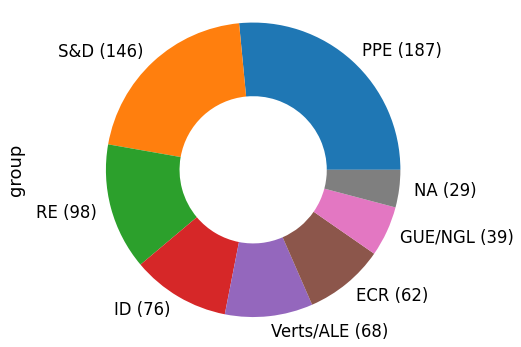

In [10]:
group_counts = df_meps.loc[df_meps['active'], 'group'].value_counts()
labels = group_counts.to_frame().apply(lambda x: f'{x.name} ({x.iloc[0]})', axis=1)

ax = group_counts.plot.pie(figsize=(8, 6), labels=labels, wedgeprops=dict(width=0.5))
ax.axis('equal')

### MEP age distribution

In [11]:
df_meps['age'] = (pd.Timestamp.today() - df_meps['birthday']) / np.timedelta64(1, 'Y')

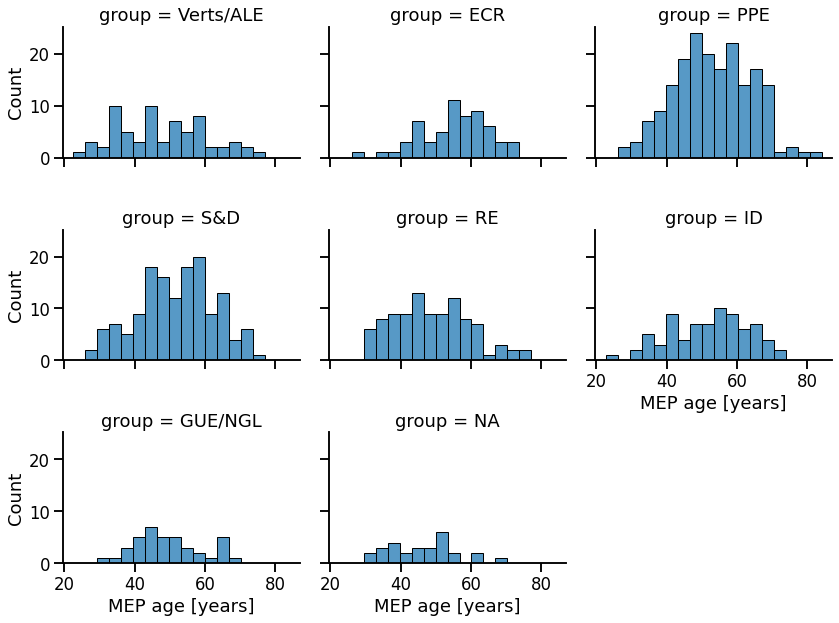

In [12]:
g = sns.displot(
    data=df_meps[df_meps['active']], x='age',
    col='group', col_wrap=3,
    height=3, aspect=4/3)

g.set_xlabels('MEP age [years]')

## Voting patterns

In [13]:
df_votematrix.head()

mepid,1,234,684,729,840,945,966,988,997,1002,...,204416,204418,204419,204420,204421,204443,204449,204733,205452,206158
voteid,,,,,,,,,,,,,,,,,,,,,
7754,NaN,NaN,+,+,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7818,-,+,-,-,NaN,-,NaN,NaN,+,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7759,+,+,+,+,NaN,+,+,NaN,+,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7755,NaN,0,+,NaN,NaN,+,0,NaN,+,+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7760,-,-,-,-,NaN,-,+,NaN,+,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Zoomed-out voting data overview

In [14]:
hm_sub = (df_votematrix.loc[df_votes[df_votes['date'] > '20200721'].index, df_meps[df_meps['active']].index]
                       .dropna(axis=1)
                       .replace({'+': 1, '-': 0, '0': -1})
                       .T
                       .merge(df_meps[['group']], how='inner', left_index=True, right_index=True)
                       .set_index('group', append=True)
                       .reorder_levels(['group', 'UserID'])
                       .sort_index())

In [15]:
hm_sub.head()

116365  116366  116368  116369  116370  116371  116326  116327  \
group UserID                                                                   
ECR   4465         1       1       1       1       1       1       1       1   
      4746         1       1       1       1       1       1       1       1   
      23712        1      -1      -1       0       0       0       0       0   
      23788        1       1       1       1       1      -1       0      -1   
      28297        1       1       1       1       1      -1       0      -1   

              116328  116329  ...  116355  116356  116357  116396  116358  \
group UserID                  ...                                           
ECR   4465         0       1  ...       1      -1       0      -1       0   
      4746         0       1  ...       1      -1       0      -1       0   
      23712        0       0  ...       0       1       0       0       0   
      23788        0       0  ...       0       0       1       1      -1   
      28297        0       0  ...       0       0       1       1      -1   

              116359  116398  116399  116360  116401  
group UserID                                          
ECR   4465         1       1       1       0      -1  
      4746         1       1       1       0      -1  
      23712       -1       1      -1       0       0  
      23788       -1       1       1       0       0  
      28297       -1       1       1       0       0  

[5 rows x 62 columns]

In [16]:
hm_sub_grpd = hm_sub.groupby('group').agg(lambda x: x.value_counts().index[0])
hm_sub_grpd.head()

,116365,116366,116368,116369,116370,116371,116326,116327,116328,116329,...,116355,116356,116357,116396,116358,116359,116398,116399,116360,116401
group,,,,,,,,,,,,,,,,,,,,,
ECR,1,1,1,1,1,-1,0,-1,0,0,...,0,0,0,1,0,-1,1,1,0,0
GUE/NGL,1,1,1,0,1,1,1,1,1,1,...,0,0,1,1,1,1,1,1,1,1
ID,1,1,0,0,1,1,0,0,1,1,...,1,1,1,1,-1,1,1,1,1,0
NA,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,1,1,1,-1,1
PPE,1,1,1,1,1,1,0,0,0,0,...,0,0,0,1,0,0,1,1,0,1


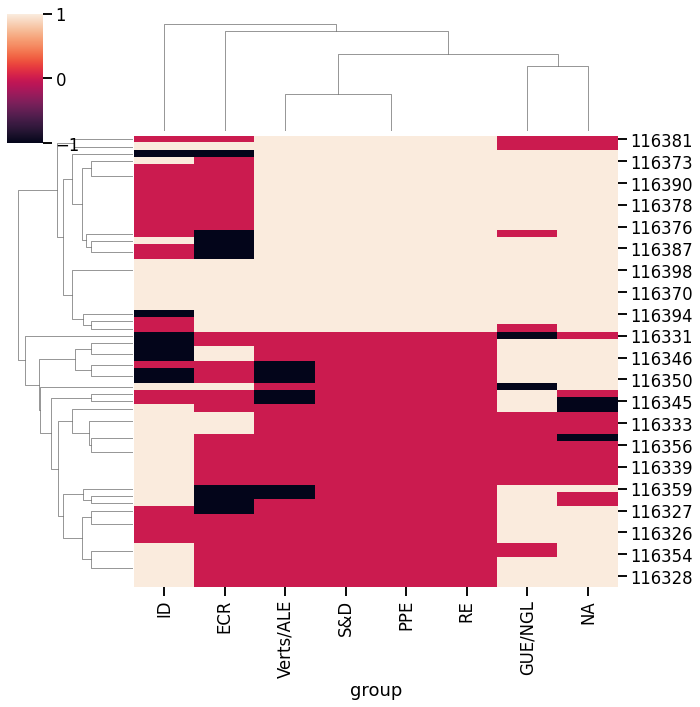

In [17]:
sns.clustermap(hm_sub_grpd.T)

### Who is the most active MEP?

Here we equate "active" with "has voted most often". This is most likely quite misleading.

In [18]:
df_hasvoted = ~df_votematrix[df_meps[df_meps['active']].index].isna()

In [19]:
df_hasvoted.sum(axis=0).sort_values(ascending=False).to_frame('vote_count').merge(df_meps, how='left', left_index=True, right_index=True).head(10)

,vote_count,name,birthday,active,group,age
mepid,,,,,,
28266,22954,Sophia in 't VELD,1963-09-13,True,RE,57.054306
1913,22703,Evelyne GEBHARDT,1954-01-19,True,S&D,66.702690
2323,22394,Rainer WIELAND,1957-02-19,True,PPE,63.617069
4246,22324,Othmar KARAS,1957-12-24,True,PPE,62.773794
28219,22324,Daniel CASPARY,1976-04-04,True,PPE,44.495526
2341,22269,Michael GAHLER,1960-04-22,True,PPE,60.446573
28224,22164,Markus PIEPER,1963-05-15,True,PPE,57.385593
28298,21992,Iratxe GARCÍA PÉREZ,1974-10-07,True,S&D,45.987686
23821,21912,József SZÁJER,1961-09-07,True,PPE,59.069405


### Cluster MEPs by votes

#### Prepare data

In [20]:
# TODO: how to handle NaN values
matrix = df_votematrix[df_meps[df_meps['active']].index].replace({'+': 1, '-': 0, '0': -1, np.nan: -1}).tail(1000)
matrix

mepid,96750,4746,23788,96810,96808,4560,38595,1992,125106,4391,...,204413,204334,204331,204346,204449,204400,197780,204733,205452,206158
voteid,,,,,,,,,,,,,,,,,,,,,
115197,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,-1
115198,1,0,0,0,1,1,1,1,0,1,...,1,0,1,0,1,1,1,1,1,-1
115055,1,0,0,0,1,1,1,1,0,1,...,1,1,0,0,1,0,0,1,1,-1
115200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,-1
115201,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112408,-1,-1,-1,-1,0,0,0,-1,0,-1,...,0,1,-1,-1,-1,0,-1,-1,-1,-1
112409,-1,-1,-1,-1,1,1,1,-1,1,-1,...,1,1,-1,-1,-1,0,-1,-1,-1,-1
112410,-1,-1,-1,-1,0,0,1,-1,0,-1,...,1,0,-1,-1,-1,0,-1,-1,-1,-1


#### Do clustering

Possible metrics:
hamming
jaccard
dice
russellrao
kulsinski
rogerstanimoto
sokalmichener
sokalsneath
yule

In [21]:
reducer = umap.UMAP(metric='hamming')

In [22]:
embedding = reducer.fit_transform(matrix.T)
embedding.shape

/Users/kimja/Library/Python/3.8/lib/python/site-packages/umap/umap_.py:1528: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


(705, 2)

In [23]:
df_umap = pd.DataFrame(embedding, index=matrix.columns, columns=[f'UMAP_{i}' for i in range(embedding.shape[1])])

df_umap['group'] = df_meps['group']

df_umap.head()

,UMAP_0,UMAP_1,group
mepid,,,
96750,-0.418295,9.059443,Verts/ALE
4746,15.113758,5.617605,ECR
23788,13.951868,-5.859007,ECR
96810,15.122217,5.607306,ECR
96808,6.651835,-4.407159,PPE


#### Static visualization

Text(0.5, 1.0, 'MEPs according to vote patterns')

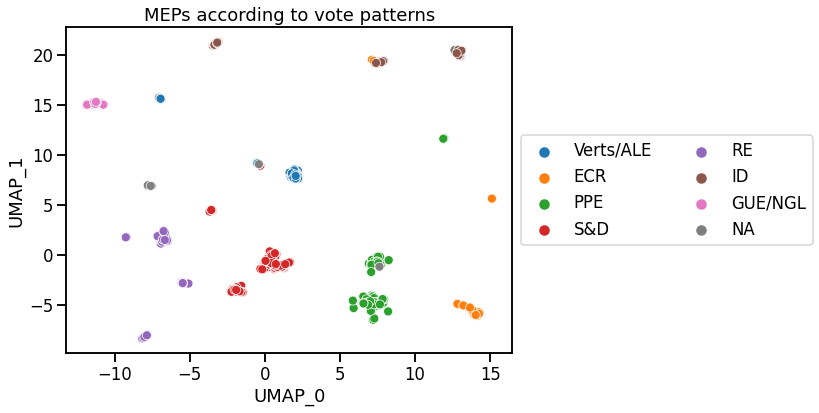

In [24]:
plt.figure(figsize=(8, 6))

sns.scatterplot(data=df_umap, x='UMAP_0', y='UMAP_1', hue='group')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, title=None)
plt.title('MEPs according to vote patterns')

# umap.plot.points(reducer, labels=df_umap['group'], theme='fire', width=1000, height=1000)

#### Interactive visualization

In [25]:
hover_data = df_meps.loc[df_umap.index].reset_index()

hover_data['birthday'] = hover_data['birthday'].apply(lambda x: x.strftime("%Y-%m-%d") if not pd.isnull(x) else 'undef')
hover_data['age'] = hover_data['age'].apply(lambda x: int(x) if not pd.isnull(x) else -1)  # hover_data['age'].round().astype(pd.Int64Dtype())

hover_data.head()

,mepid,name,birthday,active,group,age
0,96750,François ALFONSI,1953-09-14,True,Verts/ALE,67
1,4746,Sergio BERLATO,1959-07-27,True,ECR,61
2,23788,Adam BIELAN,1974-09-12,True,ECR,46
3,96810,Carlo FIDANZA,1976-09-21,True,ECR,44
4,96808,Pablo ARIAS ECHEVERRÍA,1970-06-30,True,PPE,50


In [26]:
# https://github.com/lmcinnes/umap/issues/422
# umap.plot.output_notebook()

from bokeh.plotting import output_notebook
output_notebook()

Loading BokehJS ...

In [27]:
p = umap.plot.interactive(reducer, labels=df_umap['group'].tolist(), hover_data=hover_data, point_size=5, theme='fire')
umap.plot.show(p)